In [1]:
!mkdir -p /root/.config/kaggle/
!cp /content/drive/MyDrive/kaggle.json /root/.config/kaggle/kaggle.json
!chmod 600 /root/.config/kaggle/kaggle.json

In [2]:
import kaggle

kaggle.api.authenticate()

kaggle.api.dataset_download_files('tpapp157/earth-terrain-height-and-segmentation-map-images', path="/content/segmentation", unzip=True)

Dataset URL: https://www.kaggle.com/datasets/tpapp157/earth-terrain-height-and-segmentation-map-images


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

In [17]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [5]:
# Set the directory path
dir_path = 'segmentation/'

In [6]:
# Load and preprocess data
def load_data(dir_path):
    images_dir = sorted(os.listdir(dir_path))

    img = []
    mask = []

    for file in images_dir:
        if 'i2' in file:
            mask.append(file)
        if 't' in file:
            img.append(file)

    md = pd.DataFrame({'Images': img, 'Mask': mask}, index=range(len(img)))

    return md

In [9]:
# Load the data
md = load_data(dir_path)

In [10]:
print(f"Total images: {len(md)}")
print(md.head())

Total images: 5000
       Images         Mask
0  0001_t.png  0001_i2.png
1  0002_t.png  0002_i2.png
2  0003_t.png  0003_i2.png
3  0004_t.png  0004_i2.png
4  0005_t.png  0005_i2.png


In [11]:
# Function to process and load images
def process_images(md, dir_path, shape=(128, 128)):
    df = {'Image': [], 'Mask': []}

    for i in tqdm(range(len(md))):
        i_dir = os.path.join(dir_path, md.loc[i]['Images'])
        m_dir = os.path.join(dir_path, md.loc[i]['Mask'])

        t_i = plt.imread(i_dir)
        t_m = plt.imread(m_dir)

        df['Image'].append(cv2.resize(t_i, shape))
        df['Mask'].append(cv2.resize(t_m, shape))

    return df

In [12]:
# Process and load images
df = process_images(md, dir_path)

print(f"Processed images: {len(df['Image'])}")

100%|██████████| 5000/5000 [00:58<00:00, 85.09it/s]

Processed images: 5000


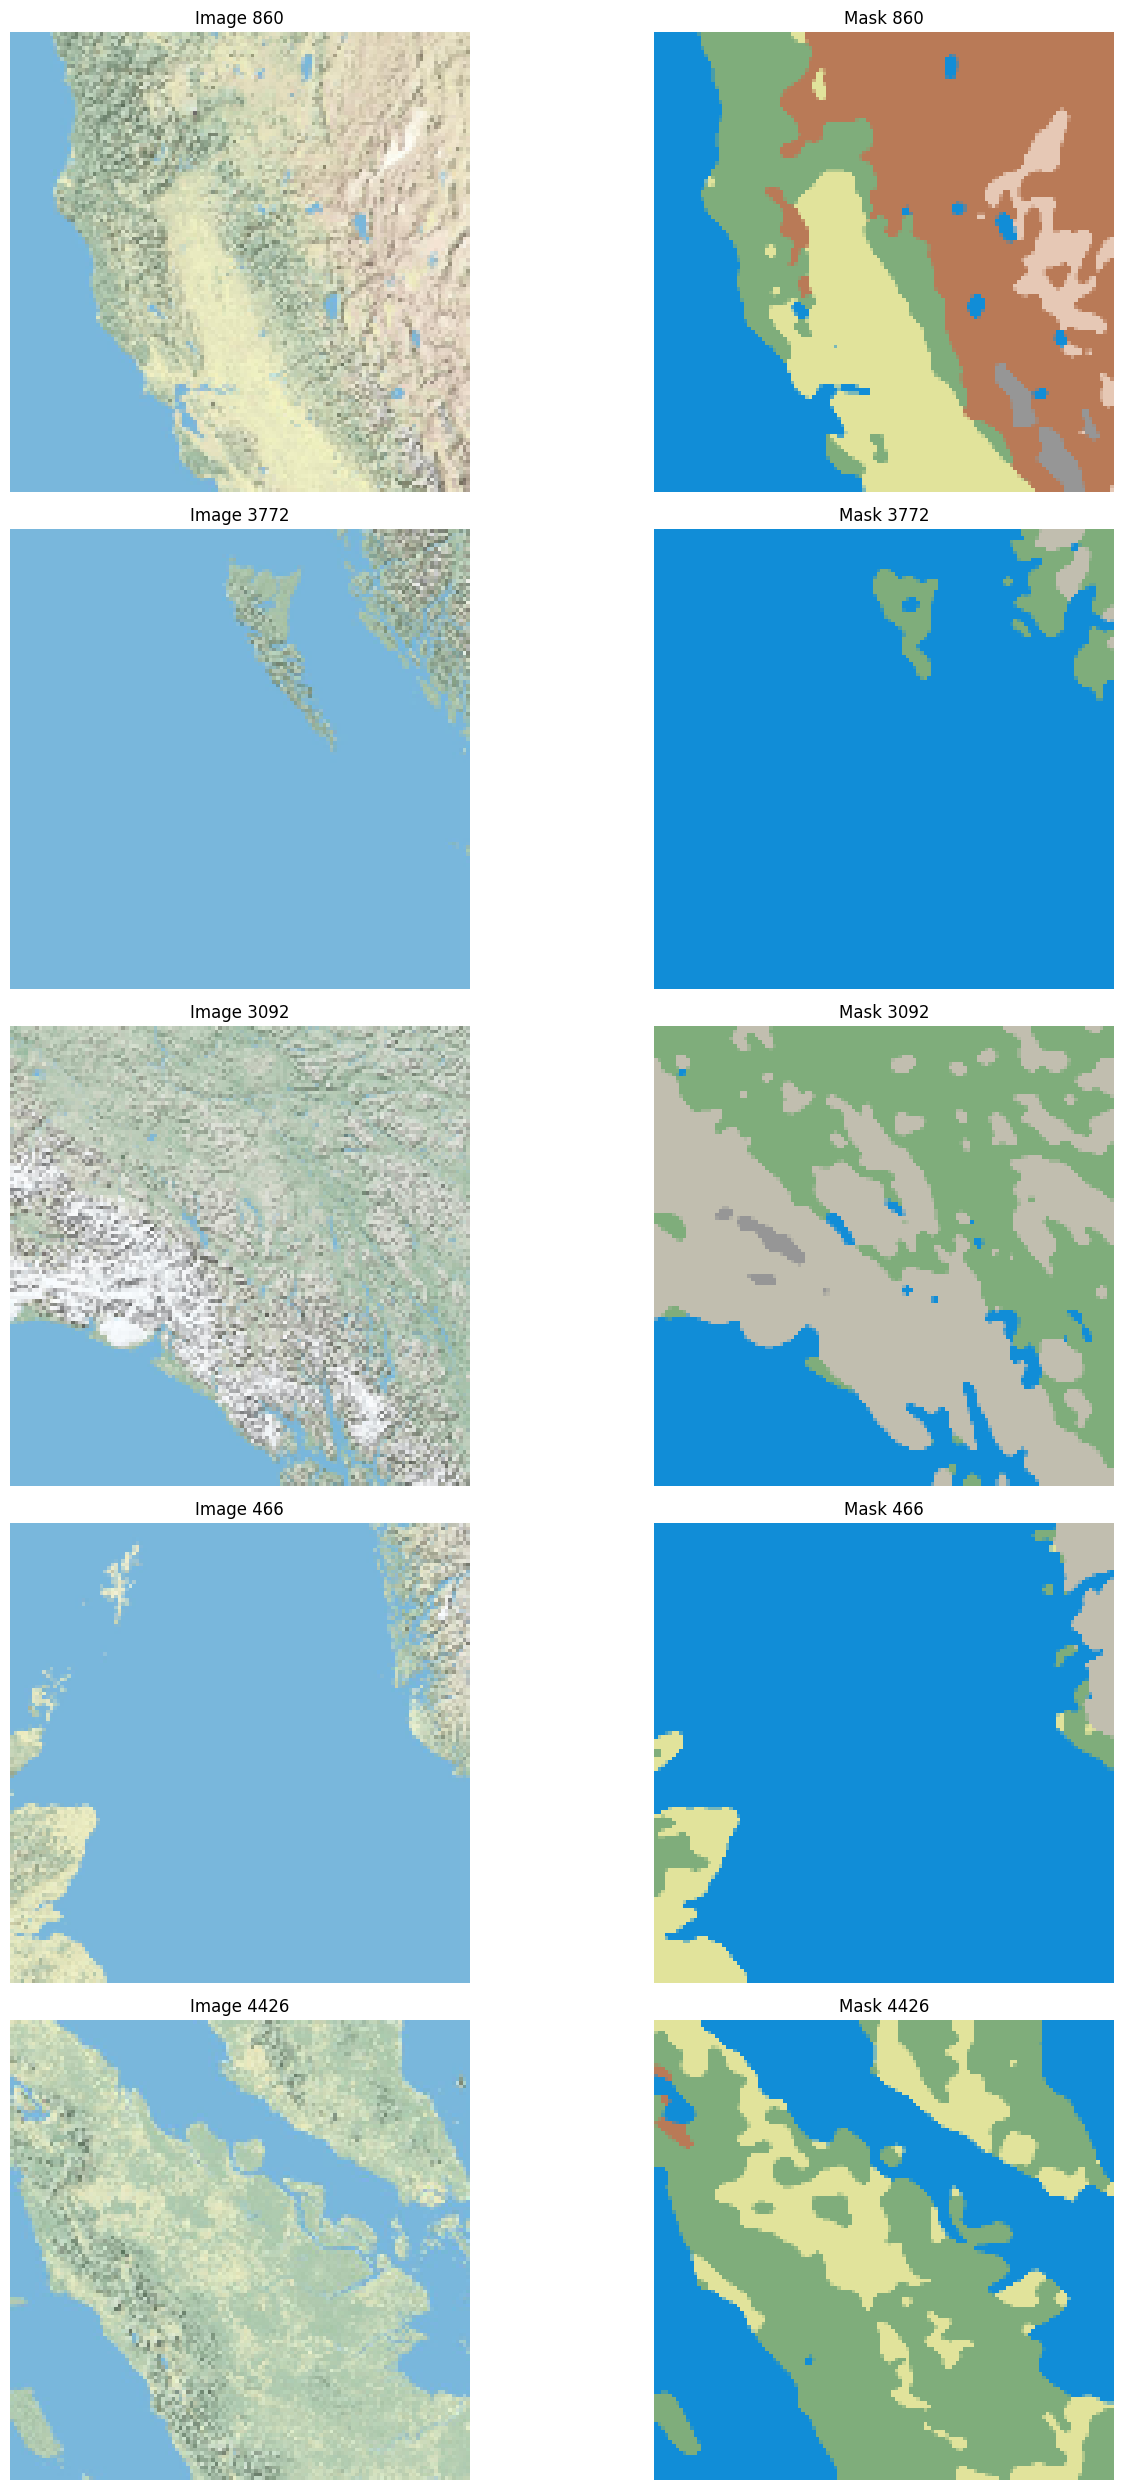

In [18]:
# Display sample images
def display_samples(df, num_samples=5):
    plt.figure(figsize=(15, 5*num_samples))
    for i in range(num_samples):
        idx = np.random.randint(0, len(df['Image']))

        plt.subplot(num_samples, 2, 2*i + 1)
        plt.imshow(df['Image'][idx])
        plt.title(f'Image {idx}')
        plt.axis('off')

        plt.subplot(num_samples, 2, 2*i + 2)
        plt.imshow(df['Mask'][idx])
        plt.title(f'Mask {idx}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

display_samples(df)

In [19]:
# Convert to numpy arrays
X = np.array(df['Image'])
y = np.array(df['Mask'])

In [20]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# Define the U-Net model
def unet_model(input_size=(128, 128, 3)):
    inputs = tf.keras.layers.Input(input_size)

    # Encoder (Downsampling)
    conv1 = conv_block(inputs, 16)
    pool1 = tf.keras.layers.MaxPooling2D((2, 2))(conv1)
    pool1 = tf.keras.layers.Dropout(0.07)(pool1)

    conv2 = conv_block(pool1, 32)
    pool2 = tf.keras.layers.MaxPooling2D((2, 2))(conv2)
    pool2 = tf.keras.layers.Dropout(0.07)(pool2)

    conv3 = conv_block(pool2, 64)
    pool3 = tf.keras.layers.MaxPooling2D((2, 2))(conv3)
    pool3 = tf.keras.layers.Dropout(0.07)(pool3)

    conv4 = conv_block(pool3, 128)
    pool4 = tf.keras.layers.MaxPooling2D((2, 2))(conv4)
    pool4 = tf.keras.layers.Dropout(0.07)(pool4)

    # Bridge
    conv5 = conv_block(pool4, 256)

    # Decoder (Upsampling)
    up6 = upsample_block(conv5, conv4, 128)
    conv6 = conv_block(up6, 128)

    up7 = upsample_block(conv6, conv3, 64)
    conv7 = conv_block(up7, 64)

    up8 = upsample_block(conv7, conv2, 32)
    conv8 = conv_block(up8, 32)

    up9 = upsample_block(conv8, conv1, 16)
    conv9 = conv_block(up9, 16)

    outputs = tf.keras.layers.Conv2D(3, (1, 1), activation='sigmoid')(conv9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model

def conv_block(inputs, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same', kernel_initializer='he_normal')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    return x

def upsample_block(inputs, skip_features, num_filters):
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(inputs)
    x = tf.keras.layers.concatenate([x, skip_features])
    x = tf.keras.layers.Dropout(0.07)(x)
    x = conv_block(x, num_filters)
    return x

In [22]:
# Create and compile the model
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [23]:
# Display model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 16)   │            448 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128, 16)   │             64 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 128, 128, 16)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 16)   │          2,320 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 16)   │             64 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 128, 128, 16)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 16)     │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64, 64, 16)     │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 32)     │          4,640 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 64, 32)     │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 64, 64, 32)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 32)     │          9,248 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 64, 64, 32)     │            128 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 64, 64, 32)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 32)     │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)  

 Total params: 2,341,107 (8.93 MB)

 Trainable params: 2,337,203 (8.92 MB)

 Non-trainable params: 3,904 (15.25 KB)

In [24]:
# Callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.weights.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min')

In [25]:
# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=80, validation_data=(X_val, y_val), callbacks=[checkpoint])

Epoch 1/80
125/125 ━━━━━━━━━━━━━━━━━━━━ 44s 62ms/step - accuracy: 0.6213 - loss: 0.6236 - val_accuracy: 0.4744 - val_loss: 0.6481
Epoch 2/80
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.7986 - loss: 0.5682 - val_accuracy: 0.6783 - val_loss: 0.6037
Epoch 3/80
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.8012 - loss: 0.5649 - val_accuracy: 0.7616 - val_loss: 0.5947
Epoch 4/80
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.8057 - loss: 0.5635 - val_accuracy: 0.8105 - val_loss: 0.5809
Epoch 5/80
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.8084 - loss: 0.5624 - val_accuracy: 0.8320 - val_loss: 0.5680
Epoch 6/80
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.8130 - loss: 0.5615 - val_accuracy: 0.8002 - val_loss: 0.5653
Epoch 7/80
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8179 - loss: 0.5607 - val_accuracy: 0.7700 - val_loss: 0.9755
Epoch 8/80
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8208 - loss: 0.5604 - val_acc

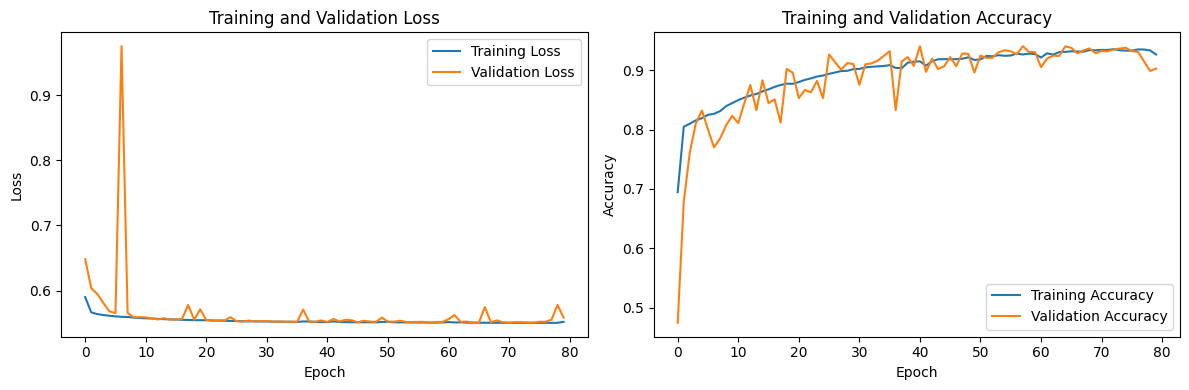

In [26]:
# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [27]:
# Load best weights
model.load_weights('best_model.weights.h5')

In [28]:
# Save the entire model
model.save('/content/drive/MyDrive/ML/Land-Segmentation/Land-Segmentation.keras')

print("Model saved successfully.")

Model saved successfully.


In [29]:
# Make predictions on validation set
y_pred = model.predict(X_val)

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step


In [31]:
# Calculate additional metrics
def calculate_metrics(y_true, y_pred, threshold=0.5):
    y_true_flat = y_true.reshape(-1, 3) > threshold
    y_pred_flat = y_pred.reshape(-1, 3) > threshold

    precision = precision_score(y_true_flat, y_pred_flat, average='macro')
    recall = recall_score(y_true_flat, y_pred_flat, average='macro')
    f1 = f1_score(y_true_flat, y_pred_flat, average='macro')

    # Calculate mIoU
    iou_scores = []
    for i in range(3):  # For each channel
        intersection = np.logical_and(y_true[..., i] > threshold, y_pred[..., i] > threshold)
        union = np.logical_or(y_true[..., i] > threshold, y_pred[..., i] > threshold)
        iou_scores.append(np.sum(intersection) / np.sum(union))
    miou = np.mean(iou_scores)

    return precision, recall, f1, miou

# Update the metrics calculation and printing
precision, recall, f1, miou = calculate_metrics(y_val, y_pred)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Mean IoU: {miou:.4f}")

Precision: 0.8978
Recall: 0.9937
F1-score: 0.9405
Mean IoU: 0.8922


In [32]:
# Function for getting 16 predictions
def predict16(val_data, model):
    img = val_data['Image'][:16]
    mask = val_data['Mask'][:16]

    predictions = model.predict(img)

    return predictions, img, mask

In [33]:
# Function for plotting predictions
def plot_predictions(img, pred_mask, ground_truth):
    plt.figure(figsize=(20, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Terrain Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    # Apply sharpening filter
    sharpen_kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    pred_mask_sharp = cv2.filter2D(pred_mask, -1, sharpen_kernel)

    plt.imshow(cv2.cvtColor(pred_mask_sharp, cv2.COLOR_BGR2RGB))
    plt.title('Predicted Terrain Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(ground_truth, cv2.COLOR_BGR2RGB))
    plt.title('Actual Terrain Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [34]:
# Make predictions and plot results
sixteen_predictions, actuals, masks = predict16({'Image': X_val, 'Mask': y_val}, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


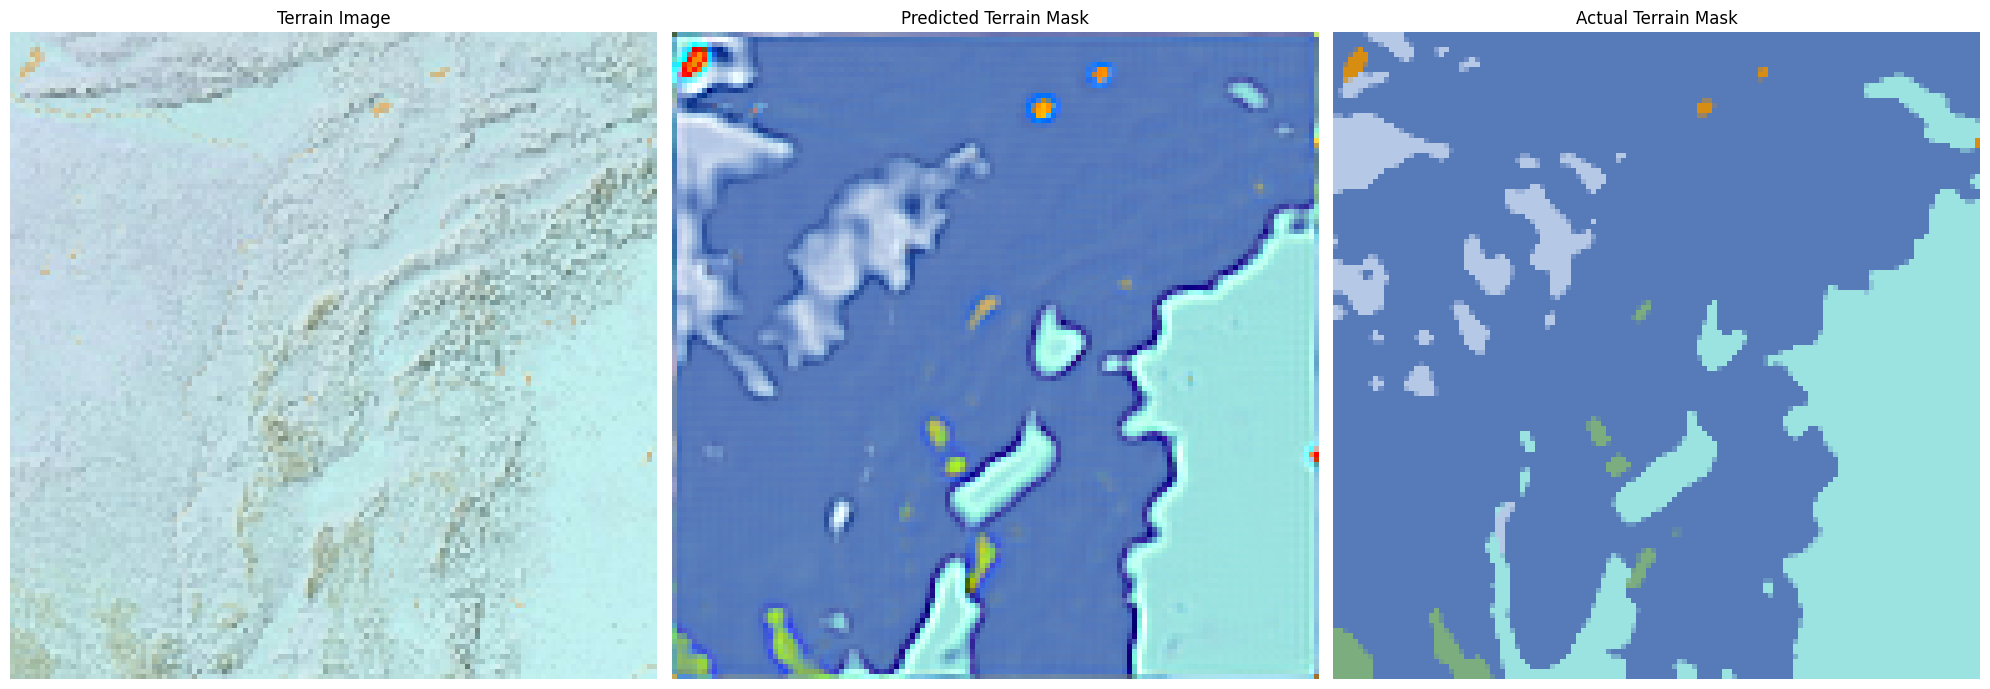

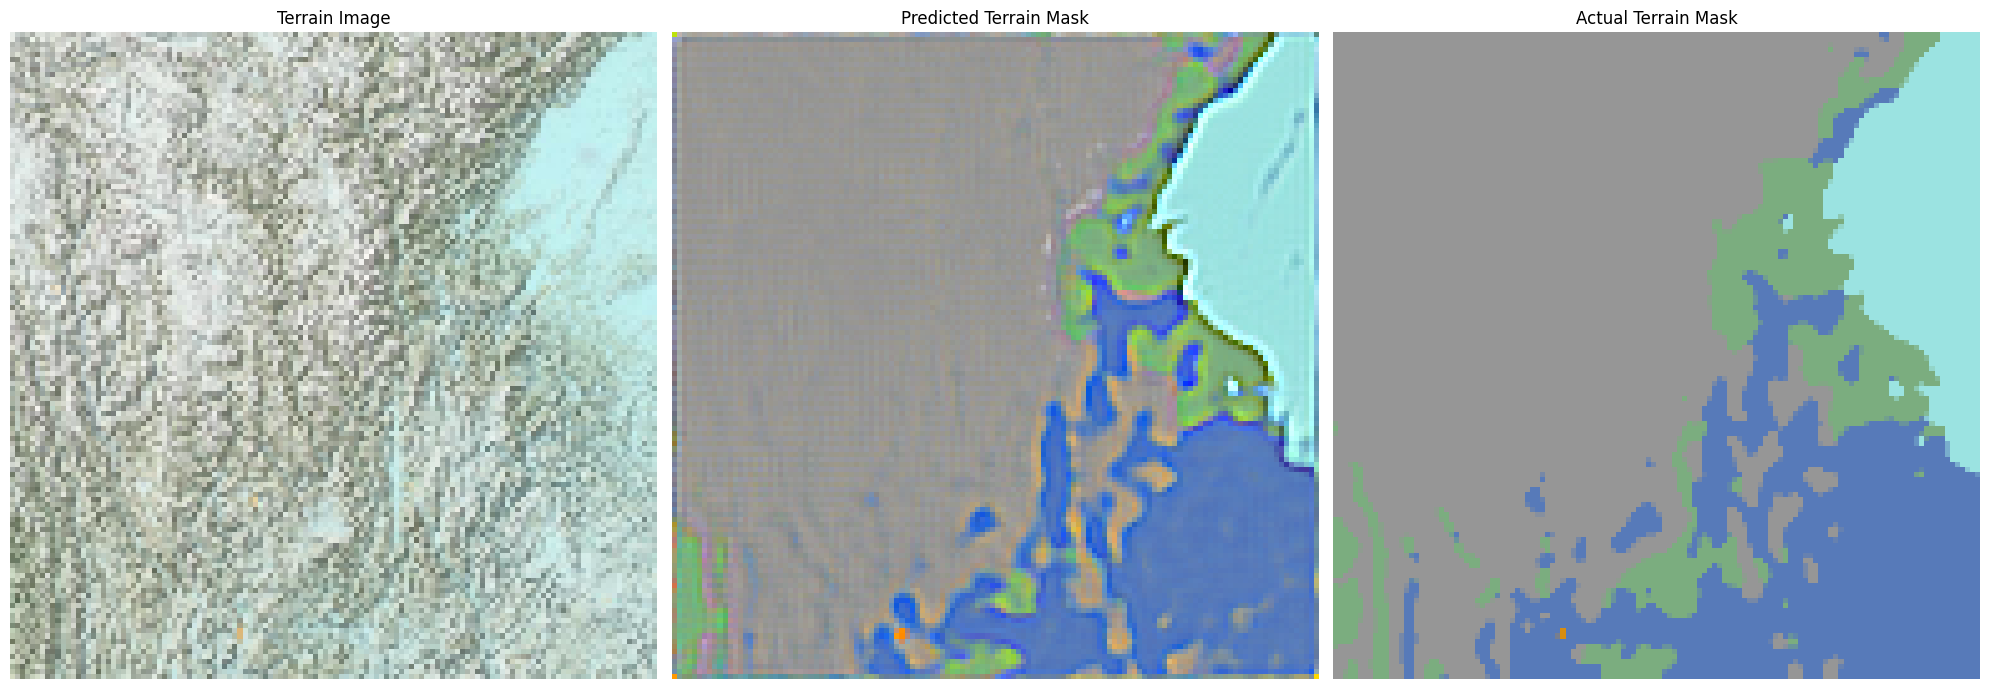

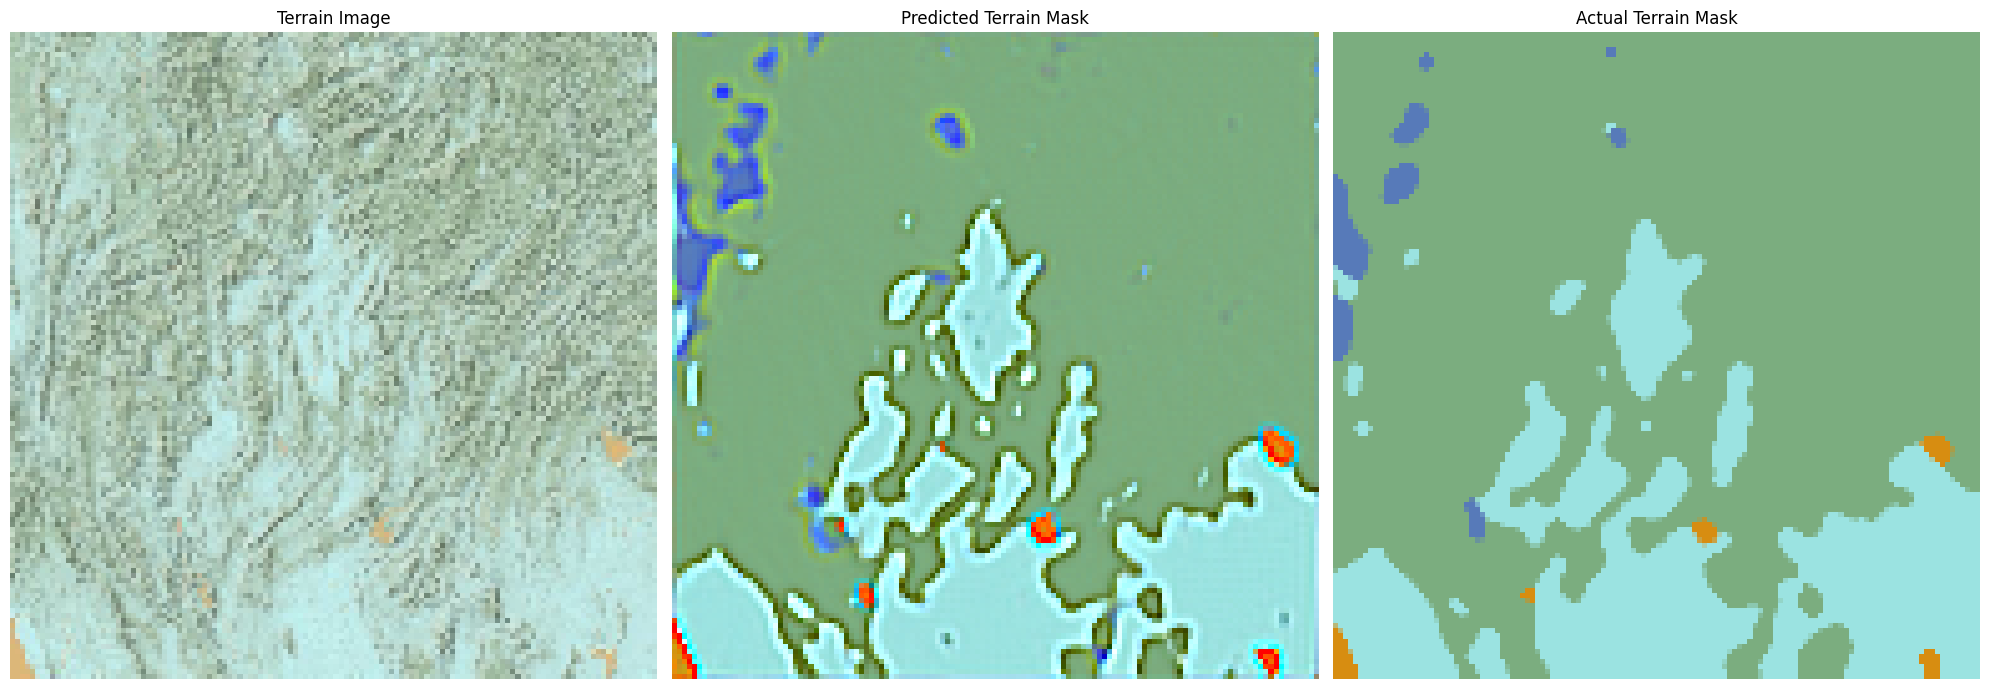

In [35]:
for i in range(3):  # Plot 3 samples
    plot_predictions(actuals[i], sixteen_predictions[i], masks[i])